In [1]:
import argparse
import cv2
import os
from os.path import exists,join, split, dirname
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import sys 
sys.path.append('../')
from PIL import Image
import torch 
import torch.utils.data
from torch import nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from segment import SegList

import dla_up 
import data_transforms2 as transforms
import dataset
import pdb

try:
    from modules import batchnormsync
    HAS_BN_SYNC = True 
except ImportError:
    HAS_BN_SYNC = True 
    
torch.set_default_tensor_type('torch.cuda.FloatTensor')

%matplotlib inline

In [ ]:
a = []
a.append('1')
print(a)

In [2]:
# read normal depth and rgb into list and pass through to transforms
normal_image = Image.open('/media/sastrygrp2/Backup/boundary_data/unhidden/VSNormals/1.png')
depth_image = Image.open('/media/sastrygrp2/Backup/boundary_data/unhidden/CustomDepth/1.png')
rgb_image = Image.open('/media/sastrygrp2/Backup/boundary_data/unhidden/RGB/1.png')
layout_guess_image = Image.open('/media/sastrygrp2/Backup/boundary_data/unhidden/Lines_w_normals/1.png')
label = Image.open('/media/sastrygrp2/Backup/boundary_data/unhidden/Layout/1.png')

In [ ]:
print(normal_image.size)
print(depth_image.size)
print(rgb_image.size)

In [ ]:
plt.imshow(np.asarray(normal_image))
print(np.asarray(normal_image).shape)

In [ ]:
plt.imshow(np.asarray(depth_image))
print(np.asarray(depth_image).shape)

In [ ]:
plt.imshow(np.asarray(rgb_image))
print(np.asarray(rgb_image).shape)

In [ ]:
print(np.asarray(label).shape)

In [3]:
image_stack = [rgb_image]
image_stack.append(normal_image)
# image_stack.append(depth_image)
image_stack.append(layout_guess_image)
# image_stack = tuple(image_stack)

In [4]:
data_dir = '/media/sastrygrp2/Backup/boundary_data/unhidden/'
info = dataset.load_dataset_info(data_dir)
normalize = transforms.Normalize(mean=info.mean, std=info.std)

In [19]:
print(len(info.mean))

7


In [5]:
t = []
random_rotate = 10
random_scale = 0
random_color = False
crop_size = 480
if random_rotate > 0:
    t.append(transforms.RandomRotate(random_rotate))
if random_scale > 0:
    t.append(transforms.RandomScale(random_scale))
t.append(transforms.RandomCrop(crop_size))
if random_color:
    t.append(transforms.RandomJitter(0.4, 0.4, 0.4))
t.extend([transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          normalize])

final_transform = transforms.Compose(t)

In [6]:
input_to_nn = final_transform.__call__(image_stack, label)

In [10]:
print(input_to_nn[0].shape)

torch.Size([7, 480, 480])


In [12]:
numpy_input_to_nn = input_to_nn[0].data.numpy()

(480, 480)


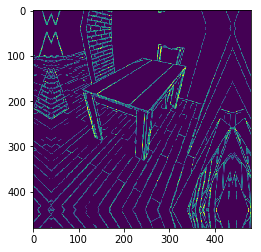

In [17]:
# tmp = np.rollaxis(numpy_input_to_nn[6,:,:], 0, 3)
tmp = numpy_input_to_nn[6,:,:]
print(tmp.shape)
# plt.imshow(cv2.cvtColor(np.squeeze(tmp[:,:,0:3]), cv2.COLOR_RGB2BGR))
plt.imshow(np.squeeze(tmp))
plt.show()

In [ ]:
print(len(image_stack))
r_object = transforms.RandomHorizontalFlip()
image, label = r_object.__call__(image_stack, label)

In [ ]:
plt.imshow(np.asarray(image_stack[0]))

In [ ]:
plt.imshow(np.asarray(image_stack[1]))

In [ ]:
plt.imshow(np.asarray(image_stack[2]))

In [ ]:
plt.imshow(np.asarray(image_stack[3])*255)

In [ ]:
# import pytorch model 
# model = torch.load('../model_best.pth.tar')
model = torch.load('../checkpoint_1200.pth.tar')
# model = torch.load('/media/sastrygrp2/Backup/dla/boundary_data/unhidden/w_layout/model_best.pth.tar')

In [ ]:
phase = 'val'
data_dir = '/media/sastrygrp2/Backup/boundary_data/unhidden/'
# data_dir = 'C:/Users/biosim/oladapo/data/Cityscape/'
t = []

info = dataset.load_dataset_info(data_dir)
normalize = transforms.Normalize(mean=info.mean, std=info.std)
# scales = [0.5, 0.75, 1.25, 1.5, 1.75]
scales = [0.5, 0.75, 1.25, 1.5]
t = []
crop_size = 416
# if args.crop_size > 0:
t.append(transforms.RandomCrop(crop_size))
# t.append(transforms.PadToSize(crop_size))
t.extend([transforms.ToTensor(), normalize])

data = SegList(data_dir, phase, transforms.Compose(t),
                       out_name=True, out_size=True,
                       binary= True)
test_loader = torch.utils.data.DataLoader(data,
batch_size=1, shuffle=False, num_workers=1,
pin_memory=False
)

In [ ]:
# j = 0
# for iter, (im, label, name, size) in enumerate(test_loader):
#     j = j+1
    
    
# #     tmp = np.reshape(tmp,(crop_size,crop_size, 3))
# #     plt.imshow(np.squeeze(im[0,:,:,:]))
#     plt.imshow(tmp)
#     plt.show()
    
#     if j > 0:
#         break

In [ ]:
j = 0
# print(model.keys())
single_model = dla_up.__dict__.get(model['arch'])(
        2, down_ratio=2, n_input_channels=4)
# single_model.__dict__ = model
# print(single_model)
# print(model[model.keys()[0]])


new_model = torch.nn.DataParallel(single_model).cuda()
# print(new_model)

# checkpoint = torch.load('../')

# start_epoch = checkpoint['epoch']

# best_prec1 = checkpoint['best_prec1']


new_model.load_state_dict(model['state_dict'])


# new_model = torch.nn.DataParallel(single_model).cuda()
new_model.eval()
# new_model.__dict__ = model
# print(new_model.module)
# # new_model.load_state_dict(model['state_dict'])
k = 0
boundaries_prefix = '/media/sastrygrp2/Backup/boundary_data/unhidden/'
for  iter, (im, label, name, size) in enumerate(test_loader):
    image_var = Variable(im, requires_grad=False, volatile=True)
    image_var = image_var.cuda()
    print(name)
    name_idx = name[k]
    gt_filename = boundaries_prefix +'Layout/'+ str(name_idx)[4:]
    gt_image = plt.imread(gt_filename)
    print(gt_filename)
    final = new_model.module(image_var)[0]
#     final = single_model(image_var)[0]
    _, pred = torch.max(final, 1)
    pred = pred.cpu().data.numpy()
#     print(pred.shape)
#     print(np.amax(pred[k,:,:]))
#     print(np.amin(pred[k,:,:]))
#     print(pred[k,:,:])
    pred_im = []
    pred_im = Image.fromarray(pred[k].astype(np.uint8))
    input_im =np.squeeze(im.numpy()[k])
    print(input_im.shape)
    tmp = np.rollaxis(input_im, 0, 3)
    print(tmp.shape)
    plt.imshow(cv2.cvtColor(np.squeeze(tmp[:,:,0:3]), cv2.COLOR_RGB2BGR))
    plt.show()
    plt.imshow(tmp[:,:,3])
    plt.show()
    print(np.amax(np.asarray(pred_im)))
    plt.imshow(np.asarray(pred_im))
    plt.show()
    #plt.imshow(gt_image*255)
    #plt.show()
    tmp2 = np.squeeze(np.asarray(label))
    tmp2[np.where(tmp2 >=255)] = 0
    
    plt.imshow(tmp2*255)
    plt.show()
#     plt.hist(np.squeeze(np.asarray(label)).flatten())
#     plt.show()
    user_in = input("Press Enter to continue...")
    
    if user_in == 's':
        
        # create new folder in results directory
        dirName = "./results/" + str(name_idx)[4:]
        print(dirName)
        if not os.path.exists(dirName):
            os.makedirs(dirName)
            print("Directory " , dirName ,  " Created ")
        else:    
            print("Directory " , dirName ,  " already exists")
        
        # get images to be saved, save images to directory 
        RGB_filename = boundaries_prefix +'RGB/'+ str(name_idx)[4:]
        RGB_save_filename = dirName + "/rgb.png"
        input_layer_filename = dirName + "/input_layer.png"
        guess_filename = dirName + "/guess.png"
        output_filename =  dirName + "/output.png"
        ground_truth_filename =  dirName + "/gt.png"
        
        real_RGB = cv2.imread(RGB_filename)
        cv2.imwrite(RGB_save_filename, real_RGB)
        cv2.imwrite(input_layer_filename, np.squeeze(tmp[:,:,0:3])*255)
        cv2.imwrite(guess_filename, np.squeeze(tmp[:,:,3])*255)
        cv2.imwrite(output_filename, np.asarray(pred_im)*255)
        print(np.asarray(label).shape)
        cv2.imwrite(ground_truth_filename, np.squeeze(np.asarray(label))*255)
        
    elif user_in == 'q':
        
        break
        
    else:
        continue